In [1]:
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import unets_repo
from keras import backend as K
from scipy.stats import kurtosis, skew
from skimage.measure import shannon_entropy

In [2]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data"

def load_data(ids,suj_path,mask_path):
  suj_files = os.listdir(suj_path)
  mask_files = os.listdir(mask_path)
  X = []
  Y = []

  for i in ids:
    x = np.load(os.path.join(suj_path,suj_files[i]))
    y = np.load(os.path.join(mask_path,mask_files[i]))

    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)
def batch_generator(suj_path, mask_path):
    suj_files = os.listdir(suj_path)
    indices = np.arange(len(suj_files))
    indices = np.random.permutation(indices)
    batch=[]
    while True:
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    yield load_data(batch,suj_path,mask_path)
                    batch=[]

train_gen_ds = batch_generator(os.path.join(fp1,"sujetos"),os.path.join(fp1,"mascaras"))
val_gen_ds = batch_generator(os.path.join(fp2,"sujetos"),os.path.join(fp2,"mascaras"))

In [3]:
def Dice(targets, inputs):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    inputs = tf.cast(inputs, dtype=tf.double)
    targets = tf.cast(targets, dtype=tf.double)
    intersection = K.sum(targets * inputs)
    
    return (2*intersection + K.epsilon()) / (K.sum(targets) + K.sum(inputs) + K.epsilon())

def Jaccard(targets, inputs):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    inputs = tf.cast(inputs, dtype=tf.double)
    targets = tf.cast(targets, dtype=tf.double)
    
    intersection = K.sum(K.abs(inputs * targets))
    union = K.sum(inputs) + K.sum(targets) - intersection
    
    return (intersection + K.epsilon())/(union + K.epsilon())

In [4]:
batch_size = 1
n_val_img = len(os.listdir(os.path.join(fp2,"sujetos")))
vspe = n_val_img//batch_size

In [5]:
attunetselu = unets_repo.AttUnet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
attunetselu.load_weights("modelsh5/0.8160_attunet_selu_lecun_aug_dicebce.h5")
unet3 = unets_repo.unet3plus(input_size=(256,256,1))
unet3.load_weights("modelsh5/0.5662_unet3plus_relu_aug_dicebce.h5")
vsunet = unets_repo.UNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=16)
vsunet.load_weights("modelsh5/0.8174_unet_v_small_selu_lecun_aug_dice.h5")
sunet = unets_repo.UNet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=32)
sunet.load_weights("modelsh5/0.7947_unet_small_relu_he_aug.h5")
unet = unets_repo.UNet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=64)
unet.load_weights("modelsh5/0.8134_unet_relu_he_aug.h5")
unetselu = unets_repo.UNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
unetselu.load_weights("modelsh5/0.8314_unet_selu_lecun_aug_dicebce.h5")
restattunet = unets_repo.ResAttUnet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64,bn=True)
restattunet.load_weights("modelsh5/0.8026_resattunet_selu_bn_dicebce.h5")
classicunet = unets_repo.classicUNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
classicunet.load_weights("modelsh5/0.8233_classicunet_selu_lecun_aug_dicebce.h5")
attunet = unets_repo.AttUnet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=64)
attunet.load_weights("modelsh5/0.8042_attunet_relu_aug_dicebce.h5")

In [49]:
nets = [attunetselu,unet3,vsunet,sunet,unet,unetselu,restattunet,classicunet,attunet]
netnames = ["AttUnet w/s","Unet3+","vsUnet","sUnet","Unet","Unet w/s","ResAttUnet","ClassicUnet","AttUnet"]

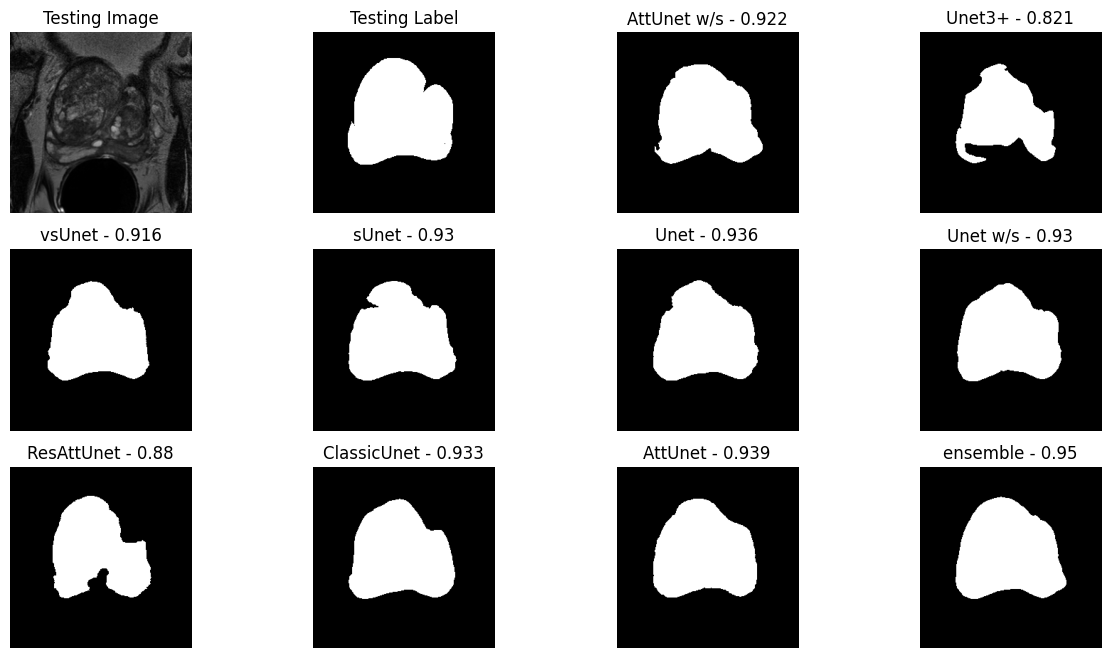

In [106]:
test_image_batch, test_mask_batch = val_gen_ds.__next__()
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth = test_mask_batch[test_img_number]
test_img_norm = test_img[:,:]
test_img_input = np.expand_dims(test_img_norm, 0)

plt.figure(figsize=(15,8))
plt.subplot(341)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.axis("off")
plt.subplot(342)
plt.title('Testing Label')
plt.imshow(ground_truth>0.5, cmap='gray')
plt.axis("off")
for i,n in enumerate(nets):
    prediction = n(test_img_input).numpy()
    prediction_th= (prediction[0,:,:,0]>0.65)*1
    dice = Dice(ground_truth,prediction_th).numpy()
    plt.subplot(3,4,i+3)
    plt.title(netnames[i]+" - "+str(round(dice,3)))
    plt.imshow(prediction_th, cmap='gray')
    plt.axis("off")
#prediction = nets[0](test_img_input).numpy()*614/1228 + nets[1](test_img_input).numpy()*106/1228 + nets[2](test_img_input).numpy()*62/1228 + nets[3](test_img_input).numpy()*85/1228 + nets[4](test_img_input).numpy()*80/1228 + nets[5](test_img_input).numpy()*65/1228 + nets[6](test_img_input).numpy()*77/1228 + nets[7](test_img_input).numpy()*69/1228 + nets[8](test_img_input).numpy()*70/1228
prediction = nets2[0](test_img_input).numpy()>index[0]*233/740
prediction += nets2[1](test_img_input).numpy()>index[1]*251/740
prediction += nets2[2](test_img_input).numpy()>index[2]*256/740
#prediction = nets[0](test_img_input).numpy()*704/1228 + nets[1](test_img_input).numpy()*169/1228 + nets[3](test_img_input).numpy()*192/1228 + nets[4](test_img_input).numpy()*163/1228
#predicted = nets[0](test_img_input).numpy()*757/1228 + nets[1](test_img_input).numpy()*206/1228 + nets[3](test_img_input).numpy()*265/1228
prediction_th = (prediction[0,:,:,0]>0.15)*1
dice = Dice(ground_truth,prediction_th).numpy()
plt.subplot(3,4,12)
plt.title("ensemble - "+str(round(dice,3)))
plt.imshow(prediction_th, cmap='gray')
plt.axis("off")
plt.show()

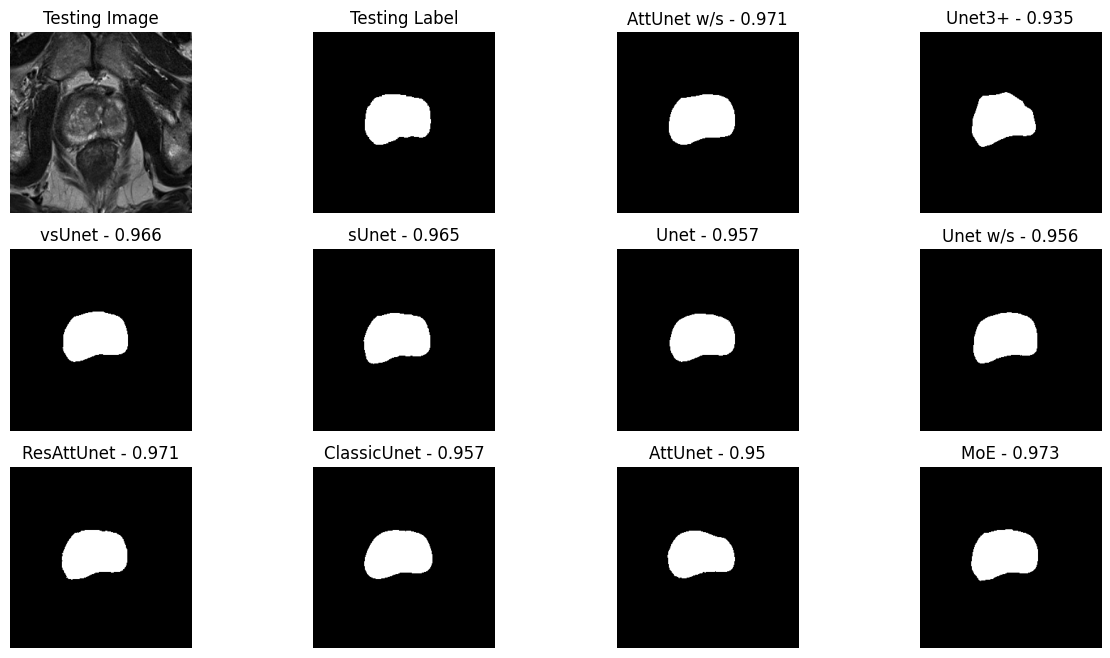

In [316]:
test_image_batch, test_mask_batch = val_gen_ds.__next__()
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth = test_mask_batch[test_img_number]
test_img_norm = test_img[:,:]
test_img_input = np.expand_dims(test_img_norm, 0)

plt.figure(figsize=(15,8))
plt.subplot(341)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.axis("off")
plt.subplot(342)
plt.title('Testing Label')
plt.imshow(ground_truth>0.5, cmap='gray')
plt.axis("off")
images = []
for i,n in enumerate(nets):
    prediction = n(test_img_input).numpy()
    prediction_th= (prediction[0,:,:,0]>indices[i])*1
    dice = Dice(ground_truth,prediction_th).numpy()
    plt.subplot(3,4,i+3)
    plt.title(netnames[i]+" - "+str(round(dice,3)))
    plt.imshow(prediction_th, cmap='gray')
    plt.axis("off")
    #images.append((prediction[0,:,:,0]>indices[i])*1)
prediction = np.zeros(shape=(1,256,256,256))
for i,net in enumerate(nets2):
    prediction += ((net(test_img_input).numpy())>index[i])*coeff2[i]/sum(coeff2)
predicted_img_th = (prediction[0,:,:,0]>0.4)*1
dice = Dice(ground_truth,predicted_img_th).numpy()
plt.subplot(3,4,12)
plt.title("MoE - "+str(round(dice,3)))
plt.imshow(predicted_img_th, cmap='gray')
plt.axis("off")
plt.show()

In [147]:
dice3 = 0
for _ in range(n_val_img):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    p1 = nets[8](test_img_input).numpy()
    pth1 = (p1[0,:,:,0]>0.75)*1
    p2 = nets[3](test_img_input).numpy()
    pth2 = (p1[0,:,:,0]>0.65)*1
    p3 = nets[1](test_img_input).numpy()
    pth3 = (p1[0,:,:,0]>0.45)*1
    pfinal = (((pth1+pth2+pth3)/3)>0.5)*1
    dice3 += Dice(ground_truth,pfinal).numpy()
print(dice3/n_val_img)

0.8329553872412299


3 redes ponderadas0.8570098563337372 th=0.65

In [143]:
pond = np.add(coeff,coeff_n)

In [144]:
pond

array([654, 635, 606, 684, 620, 608, 603, 633, 657])

In [ ]:
attunetselu = unets_repo.AttUnet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
attunetselu.load_weights("modelsh5/0.8160_attunet_selu_lecun_aug_dicebce.h5")
unet3 = unets_repo.unet3plus(input_size=(256,256,1))
unet3.load_weights("modelsh5/0.5662_unet3plus_relu_aug_dicebce.h5")
vsunet = unets_repo.UNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=16)
vsunet.load_weights("modelsh5/0.8174_unet_v_small_selu_lecun_aug_dice.h5")
sunet = unets_repo.UNet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=32)
sunet.load_weights("modelsh5/0.7947_unet_small_relu_he_aug.h5")
unet = unets_repo.UNet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=64)
unet.load_weights("modelsh5/0.8134_unet_relu_he_aug.h5")
unetselu = unets_repo.UNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
unetselu.load_weights("modelsh5/0.8314_unet_selu_lecun_aug_dicebce.h5")
restattunet = unets_repo.ResAttUnet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64,bn=True)
restattunet.load_weights("modelsh5/0.8026_resattunet_selu_bn_dicebce.h5")
classicunet = unets_repo.classicUNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
classicunet.load_weights("modelsh5/0.8233_classicunet_selu_lecun_aug_dicebce.h5")
attunet = unets_repo.AttUnet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=64)
attunet.load_weights("modelsh5/0.8042_attunet_relu_aug_dicebce.h5")

In [139]:
netnames = ["AttUnet w/s","Unet3+","vsUnet","sUnet","Unet","Unet w/s","ResAttUnet","ClassicUnet","AttUnet"]
nets = [attunetselu,unet3,vsunet,sunet,unet,unetselu,restattunet,classicunet,attunet]
coeff =   [95, 123, 52, 131, 64, 76, 66, 89, 112] #cuantas fueron el mejor dice de las imagenes con prostata
          [s,  r,   s,  r,   r,  s,  s,  s,  r]
       #  [90, 120, 47, 126, 60, 74, 62, 87, 107, 35]
coeff_n = [559, 512, 554, 553, 556, 532, 537, 544, 545] # +1 si dijieron q es full background y era.
indices = [0.95, 0.45, 0.7, 0.65, 0.85, 0.95, 0.95, 0.95, 0.75]
pond = np.add(coeff,coeff_n)

todas nets = 0.859 th 0.5
att unet x2 + unet3+ small = 0.859 th 0.4
att w/s + unet3 + small = 0.857 th 0.5
att w/s + unet3 + small + classic = 0.86 th 0.4

In [221]:
nets2 = [nets[0],nets[1],nets[3],nets[7]]
index = [indices[0],indices[1],indices[3],indices[7]]
#coeff2 = [165, 185, 206, 194]0138
#coeff2 = [218, 228, 294] 013
coeff2 = [169, 201, 228, 161] #0137

In [260]:
dice3 = 0
for _ in range(n_val_img):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    prediction = np.zeros(shape=(1,256,256,256))
    for i,net in enumerate(nets2):
        prediction += ((net(test_img_input).numpy())>index[i])*coeff2[i]/sum(coeff2)
    predicted_img_th = (prediction[0,:,:,0]>0.4)*1
    dice3 += Dice(ground_truth,predicted_img_th).numpy()
print(dice3/n_val_img)

0.8603819215897119


In [221]:
dices = []
for net in nets:
    dice = []
    for th in [0.05+0.05*i for i in range(19)]: #0.05-1
        dice_th = 0
        for _ in range(n_val_img):
            test_image_batch, test_mask_batch = val_gen_ds.__next__()
            test_img = test_image_batch[0]
            ground_truth = test_mask_batch[0]
            test_img_norm = test_img[:,:]
            test_img_input = np.expand_dims(test_img_norm, 0)
            prediction = nets2[0](test_img_input).numpy()>index[0]*233/740
            prediction += nets2[1](test_img_input).numpy()>index[1]*251/740
            prediction += nets2[2](test_img_input).numpy()>index[2]*256/740
            predicted_img_th = (prediction[0,:,:,0]>th)*1
            dice_th += Dice(ground_truth,predicted_img_th).numpy()
        dice.append(dice_th/n_val_img)
    dices.append(dice)

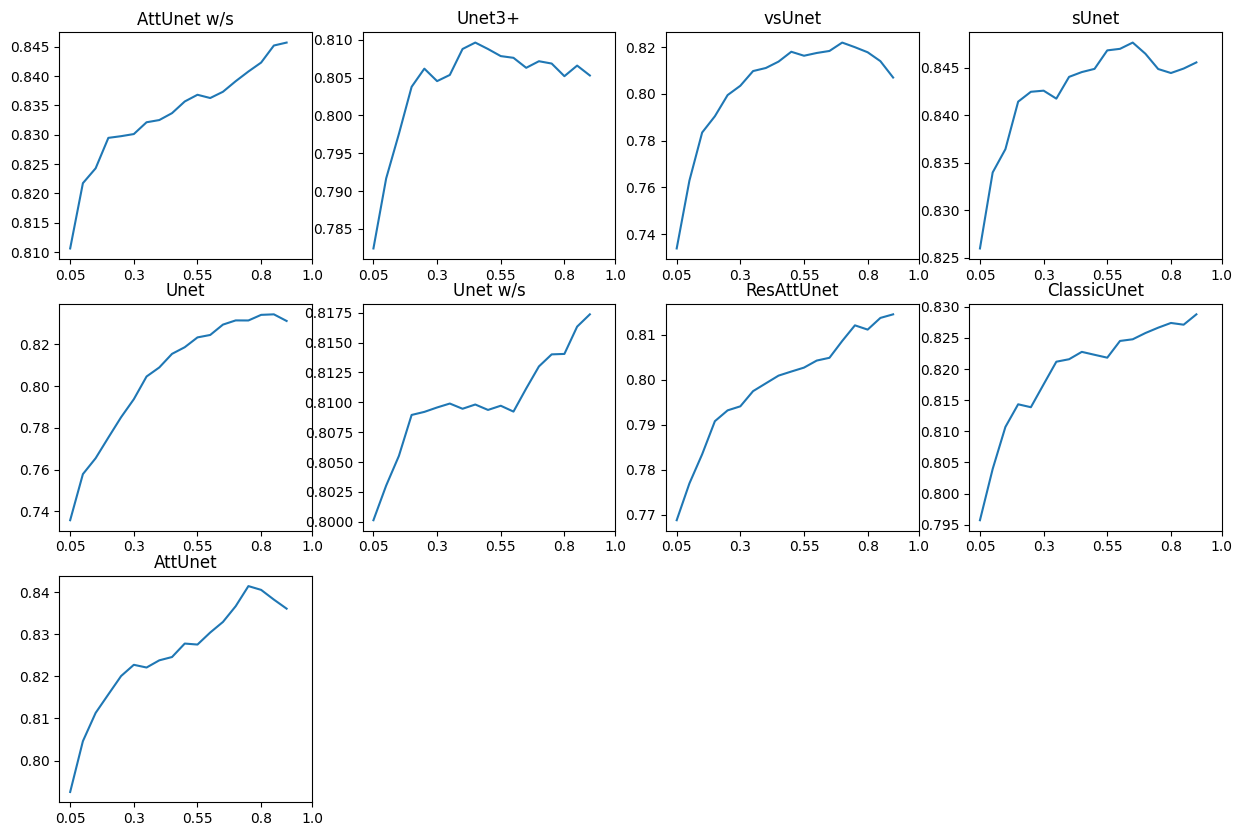

In [147]:
plt.figure(figsize=(15,10))
for i,n in enumerate(dices):
    plt.subplot(3,4,i+1)
    plt.title(netnames[i])
    plt.plot(n)
    plt.xticks([0,5,10,15,19],[0.05,0.30,0.55,0.80,1.0])

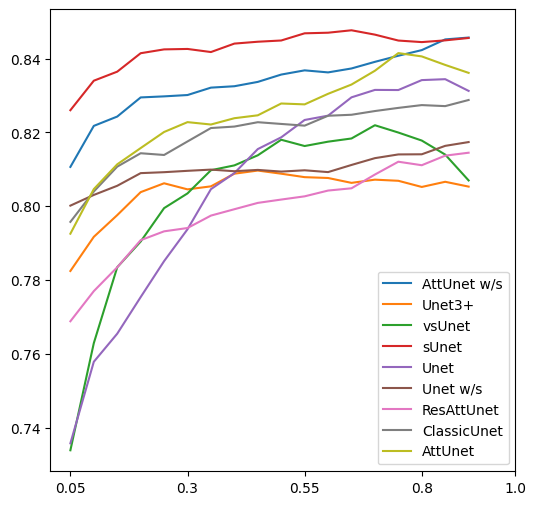

In [152]:
plt.figure(figsize=(6,6))
for i,n in enumerate(dices):
    #plt.subplot(3,4,i+1)
    #plt.title(netnames[i])
    plt.plot(n,label=netnames[i])
    plt.xticks([0,5,10,15,19],[0.05,0.30,0.55,0.80,1.0])
    plt.legend()

In [145]:
dices = [dice[0:-2] for dice in dices]

In [143]:
indices = [n.index(maxs[i])*0.05+0.05 for i,n in enumerate(dices)]

In [7]:
indices = [0.9500000000000001,
 0.45,
 0.7000000000000001,
 0.6500000000000001,
 0.8500000000000001,
 0.9500000000000001,
 0.9500000000000001,
 0.9500000000000001,
 0.7500000000000001]

In [138]:
dices

[[0.8106295864571089,
  0.821746164193009,
  0.8242766181143037,
  0.829460859268257,
  0.8297481223396876,
  0.8301095071453216,
  0.832116826181111,
  0.83249409868958,
  0.8336704916747958,
  0.8356570543359015,
  0.8367987380043096,
  0.8362452345553463,
  0.8373091990236046,
  0.8391069818303738,
  0.8407592281540008,
  0.8422847137774129,
  0.8451859433382457,
  0.8456872295224709,
  0.8457712689022799,
  0.5024429967594279],
 [0.7824193661739685,
  0.7916768012084477,
  0.797562602175925,
  0.8037891491347217,
  0.8061910154928448,
  0.8045433679969343,
  0.8053609131570252,
  0.8087918601887556,
  0.8096403354332508,
  0.8087875969804609,
  0.8078518583768325,
  0.8076246965062507,
  0.8063040073978335,
  0.8071740230019927,
  0.8068669917621121,
  0.8051959881336402,
  0.8065984949215638,
  0.805289558258545,
  0.8006588632567347,
  0.5024429967594279],
 [0.7338275211360386,
  0.7628655898280631,
  0.7834415924187444,
  0.7903992181549907,
  0.7994569574329645,
  0.80345095818

In [123]:
netnames

['AttUnet w/s',
 'Unet3+',
 'vsUnet',
 'sUnet',
 'Unet',
 'Unet w/s',
 'ResAttUnet',
 'ClassicUnet',
 'AttUnet']

In [122]:
maxs = [max(d) for d in dices]
print(maxs)

[0.8457712689022799, 0.8096403354332508, 0.8219231193939818, 0.847660539761372, 0.8344075993106885, 0.8187515987000323, 0.8167614118234443, 0.830141253332298, 0.8414765797701355]


In [208]:
asd = dict(zip(netnames,maxs))

In [137]:
asd

{'AttUnet w/s': 0.8457712689022799,
 'Unet3+': 0.8096403354332508,
 'vsUnet': 0.8219231193939818,
 'sUnet': 0.847660539761372,
 'Unet': 0.8344075993106885,
 'Unet w/s': 0.8187515987000323,
 'ResAttUnet': 0.8167614118234443,
 'ClassicUnet': 0.830141253332298,
 'AttUnet': 0.8414765797701355}

In [111]:
with open('dices_by_th.txt', 'w') as f:
    print(dices, file=f)

In [ ]:
#[614, 106, 62, 85, 80, 65, 77, 69, 70] 0.5
#[622, 100, 50, 93, 63, 69, 60, 90, 81] 0.65
#[645, 91, 49, 86, 47, 68, 61, 110, 71] 0.8
#[704, 169, 192, 163]
#[757, 206, 265]

In [151]:
scores = [0]*10
for _ in range(vspe):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    dice = 0
    for i,n in enumerate(nets):
        prediction = n(test_img_input).numpy()
        predicted_img_th = (prediction[0,:,:,0]>indices[i])*1
        dd = Dice(ground_truth,predicted_img_th).numpy()
        if ((dd!=0) and (dd!=1)):
            if dd>dice:
                dice = dd
                max_i = i
    prediction = np.zeros(shape=(1,256,256,256))
    for i,net in enumerate(nets):
        prediction += ((net(test_img_input).numpy())>indices[i])*coeff[i]/sum(coeff)
        predicted_img_th = (prediction[0,:,:,0]>indices[i])*1
        dd = Dice(ground_truth,predicted_img_th).numpy()
        if ((dd!=0) and (dd!=1)):
            if dd>dice:
                dice = dd
                max_i = 9
    if dice > 0:
        scores[max_i]+=1
print(scores)

[90, 120, 47, 126, 60, 74, 62, 87, 107, 35]


In [136]:
scores = [0]*9
for _ in range(vspe):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    dice = 0
    if not np.any(ground_truth):
        for i,n in enumerate(nets):
            prediction = n(test_img_input).numpy()
            predicted_img_th = (prediction[0,:,:,0]>indices[i])*1
            dd = Dice(ground_truth,predicted_img_th).numpy()
            if dd == 1:
                scores[i]+=1
print(scores)

[559, 512, 554, 553, 556, 532, 537, 544, 545]


In [220]:
scores2 = [0,0,0]
for _ in range(vspe):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    dice = 0
    for i,n in enumerate(nets2):
        prediction = n(test_img_input).numpy()
        predicted_img_th = (prediction[0,:,:,0]>index[i])*1
        dd = Dice(ground_truth,predicted_img_th).numpy()
        if ((dd!=0) and (dd!=1)):
            if dd>dice:
                dice = dd
                max_i = i
    if dice > 0:
        scores2[max_i]+=1
print(scores2)

[233, 251, 256]


In [219]:
nets2 = [nets[0],nets[1],nets[3],nets[7]]
index = [indices[0],indices[1],indices[3],indices[7]]

In [220]:
scores3 = [0]*len(nets2)
for _ in range(vspe):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    dice = 0
    for i,n in enumerate(nets2):
        prediction = n(test_img_input).numpy()
        predicted_img_th = (prediction[0,:,:,0]>index[i])*1
        dd = Dice(ground_truth,predicted_img_th).numpy()
        if ((dd!=0) and (dd!=1)):
            if dd>dice:
                dice = dd
                max_i = i
    if dice > 0:
        scores3[max_i]+=1
print(scores3)

[169, 201, 228, 161]


#### Búsqueda de TH dinámico a partir de características de imágenes de entrada
> Se descarta, media, std, sum(pixeles), histogram related, kurtosis, entropía, skewness, correlacion 2d. <br>
> No hay resultados viables, se propone usar threshold según dice score en validation set

In [ ]:
netnames = ["AttUnet w/s","Unet3+","sUnet","ClassicUnet"]
nets = [attunetselu,unet3,sunet,classicunet]
thresholds = [0.95,0.45,0.65,0.95] # th talque hard dice score es máx en set de validación
coeff = [169, 201, 228, 161] # cantidad de imágenes CON prostata donde obtuvieron mejor hard dice score
moe_th = 0.4 # th talque hard dice score es máx en set de validación
for unique in np.unique(prediction):
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    prediction = np.zeros(shape=(1,256,256,256))
    for i,net in enumerate(nets):
        prediction += ((net(test_img_input).numpy()) > thresholds[i])*coeff[i]/sum(coeff)
    predicted_img_th = (prediction[0,:,:,0] > unique)*1
    print(unique, Dice(ground_truth,predicted_img_th).numpy())
test_img_ravel = np.ravel(test_img)
cor = np.corrcoef(test_img)
cor_ravel = np.ravel(cor)
plt.hist(test_img_ravel,bins=1000)
plt.show()
print(np.sum(test_img_ravel))
print(kurtosis(test_img_ravel))
print(shannon_entropy(test_img))
print(skew(test_img_ravel))
plt.imshow(cor)
plt.show()
print(np.sum(cor_ravel))
print(kurtosis(cor_ravel))
print(shannon_entropy(cor))
print(skew(cor_ravel))